# MPHY0041 - CW1 - Notebook 2023/24

In [202]:
#import several libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

## Exercise 1: Decision Boundaries

### a) Compute means and standard deviations for DaT scan in the right putamen (DATSCAN_PUTAMEN_R) for the ‘HC’ and the ‘Parkinsons’ group

In [203]:
#import the file
dat_scan_file = "PPMI_DATSCAN.csv"
dat_data = pd.read_csv('PPMI_DATSCAN.csv', index_col=False)

#remove "SWEDD" data
data_filtered = dat_data[dat_data.COHORT_DEFINITION != 'SWEDD']

#extract the specific data 
dat_parkinsons = data_filtered[data_filtered['COHORT_DEFINITION'] == "Parkinson's Disease"]
dat_hc = data_filtered[data_filtered['COHORT_DEFINITION'] == 'Healthy Control']

#means
mean_park = dat_parkinsons["DATSCAN_PUTAMEN_R"].mean()
mean_hc = dat_hc["DATSCAN_PUTAMEN_R"].mean()

#standard deviations
sd_total = data_filtered["DATSCAN_PUTAMEN_R"].std()

#printing out all values
print("Mean of the right putamen for Parkinson's group: μ = ", mean_park.round(3))
print("Mean of the right putamen for Healthy controls's group: μ = ", mean_hc.round(3))
print("Standard Deviation of the dataset: σ = ", sd_total.round(3))

#decision boundary computation
decision_boundary = (mean_park + mean_hc)/2
print("Decision Boundary:", decision_boundary)

Mean of the right putamen for Parkinson's group: μ =  0.833
Mean of the right putamen for Healthy controls's group: μ =  2.157
Standard Deviation of the dataset: σ =  0.691
Decision Boundary: 1.4948489880513902


### b) Train a LinearRegression to separate Healthy control from Parkinson's disease subjects using DaT scan values for the right putamen (DATSCAN_PUTAMEN_R) and MDS UPDRS Part II score (NP2PTOT)

MODEL OUTPUTS
Score: 0.6186213680327166 
Coefficients:  [-0.40254637  0.01416262] 
Intercept:  1.165998338237147

Decision Boundary: - ( 1.166 + -0.403 * x - 0.5 )/ 0.014


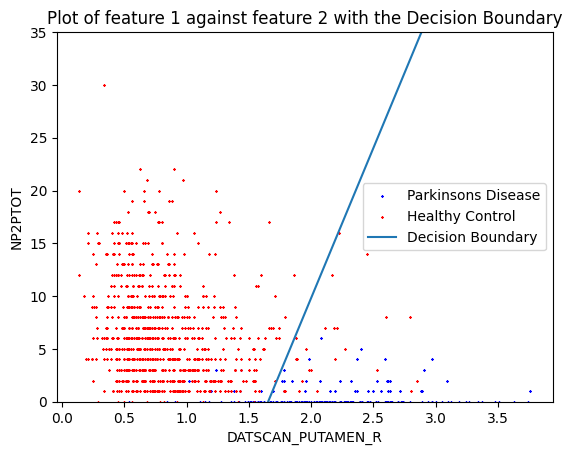

In [204]:
from sklearn.linear_model import LinearRegression

# PREPARE DATA
y = data_filtered['COHORT_DEFINITION'].apply(lambda x:0 if x == 'Healthy Control' else 1) # Binarise diagnosis e.g. HC = 1, PD = 0
X = data_filtered[['DATSCAN_PUTAMEN_R','NP2PTOT']].values # Extract the two features into one variable 

# TRAINING SECTIONS
reg = LinearRegression().fit(X, y)
reg.score(X, y)
coef = reg.coef_
intercept = reg.intercept_

# JUST PRINTING MODEL OUTPUTS
print('MODEL OUTPUTS')
print('Score:',reg.score(X, y),'\nCoefficients: ',reg.coef_,'\nIntercept: ',reg.intercept_)

# SCATTER PLOT OF THE TWO FEATURES
PD_data = X[y == 0]
HC_data = X[y == 1]

plt.scatter(PD_data[:, 0], PD_data[:, 1], c='blue', marker='x', s=1, label='Parkinsons Disease')
plt.scatter(HC_data[:, 0], HC_data[:, 1], c='red', marker='x', s=1, label='Healthy Control')

plt.xlabel('DATSCAN_PUTAMEN_R')
plt.ylabel('NP2PTOT')
plt.title('Plot of feature 1 against feature 2 with the Decision Boundary')

# DECISION BOUNDARY CALCULATION
threshold = 0.5 # decision boundary defined for regression model
x_range = np.linspace(min(X[:,0]), max(X[:,0]),100)

y_values = -(intercept + coef[0] * x_range - threshold) / coef[1] # main calculation based on y = beta0 + beta1 * x1 + beta2 * x2

plt.plot(x_range, y_values,label = 'Decision Boundary')
plt.ylim(0,35)
plt.gca().legend(loc = 'best')

# PRINT DECISION BOUNDARY EQUATION
print('\nDecision Boundary: - (', round(intercept,3) ,'+', round(coef[0],3)  ,'* x -', round(threshold,3) ,')/', round(coef[1],3))


In [205]:
dat_swedd = dat_data[dat_data['COHORT_DEFINITION'] == "SWEDD"]
mean_swedd = dat_hc["DATSCAN_PUTAMEN_R"].mean()

mean_hc_score = dat_hc["NP2PTOT"].mean()
mean_park_score = dat_parkinsons["NP2PTOT"].mean()
mean_swedd_score = dat_swedd["NP2PTOT"].mean()

print('RIGHT PUTAMEN MEANS: \n Healthy Control',round(mean_hc,3),'Parkinsons',round(mean_park,3),'SWEDD', round(mean_swedd,3))
print('NP2PTOT MEANS: \n Healthy Control',round(mean_hc_score,3),'Parkinsons',round(mean_park_score,3),'SWEDD', round(mean_swedd_score,3))

input_data = np.transpose(np.array(dat_data[['DATSCAN_PUTAMEN_R','NP2PTOT']]))
covariance_matrix = np.cov(input_data)
print('\nCOVARIANCE BETWEEN DATSCAN_PUTAMEN_R AND NP2PTOT \n',covariance_matrix)



RIGHT PUTAMEN MEANS: 
 Healthy Control 2.157 Parkinsons 0.833 SWEDD 2.157
NP2PTOT MEANS: 
 Healthy Control 0.431 Parkinsons 6.491 SWEDD 5.641

COVARIANCE BETWEEN DATSCAN_PUTAMEN_R AND NP2PTOT 
 [[ 0.52293607 -1.42186072]
 [-1.42186072 24.47762585]]


In [206]:
from scipy.stats import multivariate_normal
means = {
    'HC': np.array([mean_hc, mean_hc_score]),
    'Parkinsons': np.array([mean_park, mean_park_score]),
    'SWEDD': np.array([mean_swedd, mean_swedd_score])
}

# Create multivariate normal distributions for each class
mvn_HC = multivariate_normal(mean=means['HC'], cov=covariance_matrix)
mvn_Parkinsons = multivariate_normal(mean=means['Parkinsons'], cov=covariance_matrix)
mvn_SWEDD = multivariate_normal(mean=means['SWEDD'], cov=covariance_matrix)

# Plot the decision boundary
x_dec, y_dec = np.meshgrid(np.linspace(0, 4, 100), np.linspace(0, 35, 100))
pos = np.dstack((x_dec, y_dec))
decision_boundary_hc_pk = np.log(mvn_HC.pdf(pos) / mvn_Parkinsons.pdf(pos))
decision_boundary_hc_swedd = np.log(mvn_HC.pdf(pos) / mvn_SWEDD.pdf(pos))
decision_boundary_swedd_pk = np.log(mvn_SWEDD.pdf(pos) / mvn_Parkinsons.pdf(pos))

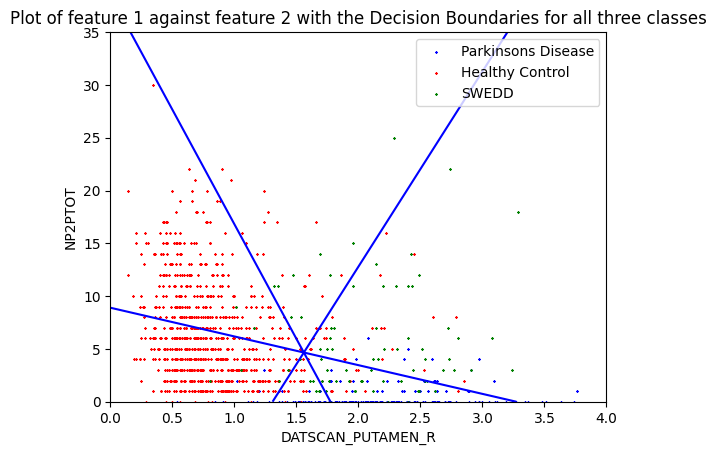

In [207]:
plt.scatter(PD_data[:, 0], PD_data[:, 1], c='blue', marker='x', s=1, label='Parkinsons Disease')
plt.scatter(HC_data[:, 0], HC_data[:, 1], c='red', marker='x', s=1, label='Healthy Control')
plt.scatter(dat_swedd['DATSCAN_PUTAMEN_R'],dat_swedd['NP2PTOT'], c='green', marker='x', s=1, label='SWEDD')

plt.xlabel('DATSCAN_PUTAMEN_R')
plt.ylabel('NP2PTOT')
plt.title('Plot of feature 1 against feature 2 with the Decision Boundaries for all three classes')

threshold = 0.5 # decision boundary defined for regression model
x_dec, y_dec = np.meshgrid(np.linspace(0, 4, 100), np.linspace(0, 35, 100))

#plt.plot(x_range, y_values,label = 'Decision Boundary')
plt.ylim(0,35)
plt.xlim(0,4)
plt.gca().legend(loc = 'best')

plt.contour(x_dec, y_dec, decision_boundary_hc_pk, levels=[0], colors='blue')
plt.contour(x_dec, y_dec, decision_boundary_hc_swedd, levels=[0], colors='blue')
plt.contour(x_dec, y_dec, decision_boundary_swedd_pk, levels=[0], colors='blue')


## Exercise 2: Regression Implementations

### a) Complete the code for Linear Regression RSS with L2 regularization


In [208]:
def fit_RSSl2_GRAD(y, features, lam=0.00, eps=1e-9, rho=1.0, maxiter=10000):
    N = features.shape[0]
    p = features.shape[1] + 1
    betas_ = np.zeros(p)
    X = np.c_[np.ones(N),features]
    yhat =  X @ betas_
    old_cost = 100000000
    cost = (1/ (2 * N)) * np.sum((yhat - y) ** 2) + lam * np.sum((betas_) ** 2)
    cnt = 0
    while (abs(old_cost - cost) > eps) and (cnt < maxiter):
        cnt += 1
        betas_ = betas_ - rho * (X.T @ (yhat - y) / N + 2 * lam * betas_)
        yhat =  X @ betas_
        old_cost = np.copy(cost)
        cost = (1/ (2 * N)) * np.sum((yhat - y) ** 2) + lam * np.sum((betas_) ** 2)
        if cost > old_cost:
            rho /= 2
    return(betas_)

In [209]:
# LOADING DATA
def load_data(file_path):
    data = pd.read_csv(file_path)
    data = np.transpose(np.array(data))
    X = data[1:]
    y = data[0]
    return X, y

X_train2, y_train2 = load_data('sim_dat.csv')
X_test2, y_test2 = load_data('sim_test.csv')

X_train2 = X_train2.T
X_test2 = X_test2.T

lam_values = [0.0, 0.4, 0.1]
beta_values = []
for lam in lam_values:
    betas = fit_RSSl2_GRAD(y_train2,X_train2,lam=lam)
    print('For lamda=',lam,'the beta coefficients are',betas)
    beta_values.append(betas)
beta_values = np.array(beta_values)

For lamda= 0.0 the beta coefficients are [-0.72551462  1.05391912 -1.27040004 -3.57447219  1.85459948]
For lamda= 0.4 the beta coefficients are [-0.40306368 -0.63430673  0.04845966 -1.05888789  0.16864887]
For lamda= 0.1 the beta coefficients are [-0.60459552 -0.45358035  0.00865712 -1.78786903  0.43402561]


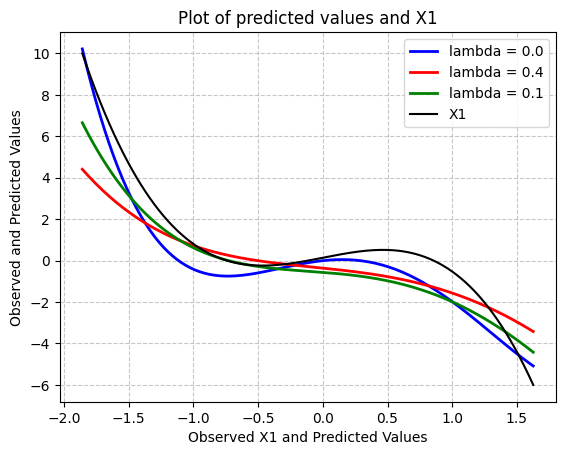

In [210]:
X_test2_plot = np.c_[np.ones(X_test2.shape[0]),X_test2]

# LAMBDA = 0.0
y_pred_test = X_test2_plot @ beta_values[0]
plt.plot(X_test2_plot[:, 1], y_pred_test, label='lambda = 0.0', color='blue', linewidth=2)

# LAMBDA = 0.4
y_pred_test = X_test2_plot @ beta_values[1]
plt.plot(X_test2_plot[:, 1], y_pred_test, label='lambda = 0.4', color='red', linewidth=2)

# LAMBDA = 0.1
y_pred_test = X_test2_plot @ beta_values[2]
plt.plot(X_test2_plot[:, 1], y_pred_test, label='lambda = 0.1', color='green', linewidth=2)

# X1
plt.plot(X_test2[:,0], y_test2, label='X1', color='black')
plt.title('Plot of predicted values and X1')
plt.xlabel('Observed X1 and Predicted Values')
plt.ylabel('Observed and Predicted Values')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()


### b) Complete the code for Linear Regression with LogCosh loss via Gradient Descent

In [211]:
#this function fits Linear Regression with LogCosh loss using Gradient Descent
#inputs are
#y:         continous values
#features:  input feature matrix
#eps:       tolerance for the stopping criterion for gradient descent
#rho:       step size in gradient descent
#maxiter: maximum iterations

#this function returns the beta coefficients for a Linear Regression model
#the first entry (betas[0] is the intercept)
def fit_logcosh_GRAD(y, features, eps=1e-9, rho=1.0, maxiter=10000):
    #sample size
    N = features.shape[0]
    #feature dim
    p = features.shape[1] + 1
    #initalize beta with 0s
    betas_ = np.zeros(p)
    #add column of 1 to X
    X = np.c_[np.ones(N),features]
    #compute predictions
    yhat =  X @ betas_

    old_cost = 100000000
    #compute the cost (J) of the current solution
    #COMPLETE THIS LINE
    cost = (1/(2 * N)) * np.sum(np.log(np.cosh(yhat - y))) 
    #as long as the there is a differentce between old and new cost that is larger
    #than the tolerance we update the parameters
    cnt = 0
    while (abs(old_cost - cost) > eps) and (cnt < maxiter):
        cnt += 1
        betas_ = betas_ - rho/N * (np.sinh(yhat-y)) /np.cosh(yhat-y) @ X

        #update predictions
        yhat =  X @ betas_

        old_cost = np.copy(cost)
        #recompute cost
        #COMPLETE THIS LINE
        cost = (1/(2 * N)) * np.sum(np.log(np.cosh(yhat - y))) 

        #reduce learning rate in case the cost increased
        #reset to previous solution
        if cost > old_cost:
            rho /= 2
    return(betas_)

The beta coefficients are [-0.89233837  0.7794377  -1.10357196 -3.3699207   1.74209075]


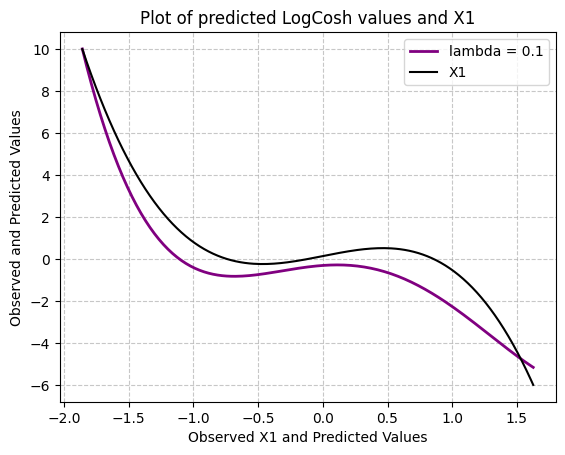

In [212]:
betas = fit_logcosh_GRAD(y_train2,X_train2)
print('The beta coefficients are',betas)

y_pred_test = X_test2_plot @ betas
plt.plot(X_test2_plot[:, 1], y_pred_test, label='lambda = 0.1', color='purple', linewidth=2)

# X1
plt.plot(X_test2[:,0], y_test2, label='X1', color='black')
plt.title('Plot of predicted LogCosh values and X1')
plt.xlabel('Observed X1 and Predicted Values')
plt.ylabel('Observed and Predicted Values')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

### c) Complete the code for linear regression with linear models for mean and standard deviation

* Deriving the Loss function:

* Deriving the gradients:


In [213]:
#this function fits Linear Regression flexible noise component N(mu(x), sigma(x))
#inputs are
#y:         continous values
#features:  input feature matrix
#eps:       tolerance for the stopping criterion for gradient descent
#rho:       step size in gradient descent
#maxiter: maximum iterations

#this function returns the beta coefficients for a Linear Regression model
#the first entry (betas[0] is the intercept)
from scipy.stats import norm

def fit_norm_GRAD(y, features, eps=1e-9, rho=0.1, maxiter=10000):
    #sample size
    N = features.shape[0]
    #feature dim
    p = features.shape[1] + 1
    #initalize beta with 0s
    betas_ = np.zeros(p)
    thetas_ = np.ones(p)
    #add column of 1 to X
    X = np.c_[np.ones(N),features]
    #compute predictions
    mu_hat =  X @ betas_
    sigma_hat = X @ thetas_

    old_cost = 100000000
    #compute the cost (J) of the current solution
    #COMPLETE THIS LINE
    cost = 0
    #as long as the there is a differentce between old and new cost that is larger
    #than the tolerance we update the parameters
    cnt = 0
    while (abs(old_cost - cost) > eps) and (cnt < maxiter):
        cnt += 1
        #beta update (one step of the gradient descent)
        #COMPLETE THIS SECTION
        betas_ -= 0
        thetas_ -= 0


        #update probabilities
        mu_hat =  X @ betas_
        sigma_hat = X @ thetas_

        old_cost = np.copy(cost)
        #recompute cost
        #COMPLETE THIS LINE
        cost = 0#

        #reduce learning rate in case the cost increased
        #reset to previous solution
        if cost > old_cost:
            rho /= 2
    return(betas_, thetas_)

In [214]:
#betas, thetas = fit_norm_GRAD(y_train2,X_train2)
#print('The beta coefficients are',betas)

## Exercise 3: Suggest improvements to the ML pipeline

### 3) Researcher A (RA) is working on a machine learning task. RA aims to classify lung CT scans into people with chronic obstructive pulmonary disease (COPD) and healthy controls. The dataset comprises 72 people with COPD and 94 controls, resulting in 154 COPD images and 207 control images. The CT data has the dimension of 70x70x35 voxels (each of size 3mm3). Because of the high dimensionality of the data, RA decides to use Support Vector Machines with a linear kernel and selects the cost (𝐶) parameter to be 10.0. RA runs a 5- fold cross-validation and measures the correlation between the output and the actual labels. The machine learning model achieved an accuracy of 0.82 and RA is now convinced the model is ready to be used in the clinic.
### State four corrections to the analysis proposed by RA and provide your reason for making each correction.


**Ideas for Further Exploration:**

- **Confusion Matrix:**
  - Evaluate false positives and negatives.


- **Parameter Tuning:**
  - Search for optimal parameters to enhance model performance.


- **Clinical Applicability:**
  - Consideration of the model's application in a clinical setting.


- **Data Set Size:**
  - Note the relatively small dataset and its implications for clinical use.


1. **Consider Multiple Metrics:**
   Measuring only the correlation between the output and actual labels is insufficient when evaluating an SVM for clinical applications. Various metrics, such as precision, recall, accuracy, and F1 score, along with the confusion matrix, provide a more comprehensive view of the model's performance. In medical data analysis, understanding how the SVM mislabels data, including false positives and negatives, is crucial.

2. AIC/BIC maybe

3. **L2 Regularization Feature:**
   SVM incorporates an L2 regularization feature, enhancing its ability to generalize well to new data.

4. **Feature Scaling is Crucial:**
   Before applying SVM, it is imperative to perform feature scaling on variables. This ensures a more effective and reliable performance of the SVM algorithm.

5. **Balancing out the number of classes or weighting things**


## Exercise 4: Retinal Fluid Segmentation

In [215]:
import imageio.v3
import os
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
from sklearn import ensemble # methods for building and combining ensemble models
from sklearn import svm
from sklearn import model_selection # provides functions for model selection and evaluation. 
# It includes tools for splitting datasets, cross-validation, and parameter tuning.
from sklearn.preprocessing import StandardScaler # used for standardizing features by removing the mean and scaling to unit variance.
from sklearn.metrics import roc_auc_score # computes the Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
from sklearn.feature_extraction import image # It provides utilities for working with image data, including patch extraction and image vectorization.
from skimage.filters import scharr # Scharr transform, which is a type of edge detection filter commonly applied to images
from skimage.color import rgb2gray # converts a color image in RGB format to grayscale

# My additions
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d

In [216]:
#helper function to read image along with mask
def read_img(pt, iname):
  img_f = os.listdir(pt + "/" + iname + "/images/")[0]
  msk_f = os.listdir(pt + "/" + iname + "/masks/")[0]
  im  = imageio.v3.imread(pt + "/" + iname + "/images/" + img_f)
  msk = imageio.v3.imread(pt + "/" + iname + "/masks/" + msk_f)
  return (im, msk)

In [217]:
train_path = './train/'
vali_path = './vali/'
test_path = './test/'

In [218]:
#this function takes an input image and
#does the manual feature extraction
#currently it simply turns the color image to a gray scale image.
#but you can modify this function to add new features
#e.g., by appling any filters.

#if the variable nchan is sset to True, then the return is just the number of channels

def preprocess_img(img, nchan=False):
    #some examples for pre-processing:

    ##do nothing
    ##copy all three channels
    #res = img

    ##just use the green channel
    #res = img[:,:,1]

    ##single channel gray
    res = rgb2gray(img) * 255

    #note some of the images are bit 'cut off' this sets the white regions to black
    res[res > 250] = 0

    #some examples for possible extensions:
    ##add the red channel
    #res = np.dstack( (res, img[:,:,1]))

    #add some edge filter applied to the green channel
    #res = np.dstack((res, scharr(img[:,:,1]) * 255))

    #NOTE: the skimage library contains useful filters

    #if nchan is True, then just return the number of channels
    #the pre-processing produces
    if nchan:
        try:
            return(res.shape[2])
        except IndexError:
            return(1)
    return (res)

In [219]:
#turn the images into a training dataset
#train_path:    path to the training data
#n_train_patch: number of patches to be extracted per image
#ps :           patch size as integer (e.g., 7 -> 7x7 patches)
#chan:          number of 'channels' the pre_processed image will have

def create_training_set(train_path, n_train_patch, ps, chan, verbose=True, process='original'):
  if verbose:
    print("Extracting " + str(n_train_patch) + " pataches of size " + str(ps) + "x" + str(ps) + " from each image.")

  #dimension of square patch
  patch_dim = (ps, ps)
  #center of the patch
  patch_cnt = int((ps-1)/2)
  #dimension of the 'flattened' patch

  flat_dim = ps*ps*chan

  #initialize Y and X
  Y = []
  X = np.empty((0,flat_dim))

  train_imgs = os.listdir(train_path)
  train_imgs = [file for file in train_imgs if ".DS_Store" not in file] # Added because this was annoying me


  for s in np.arange(400):
    if verbose:
      print("Extracting data from subject: " + str(s))

    img_m, msk_x = read_img(train_path, train_imgs[s])
    #binarize the mask
    msk = (msk_x > 0) * 1

    #extract features
    if process == 'original':
      frames = preprocess_img(img_m)
    else:
      frames = preprocess_img_feature(img_m)
    #add the labels as an additional channel
    frames = np.dstack((frames, msk))
    #sample patches
    patch = image.extract_patches_2d(frames, patch_dim, max_patches=n_train_patch)

    #each patch receives the label of the center value in the 'label' channel
    Y_tmp = patch[:, patch_cnt, patch_cnt, -1] == 1
    #turn patches into a matrix where each row corresponds to all the features
    #of one patch
    X_tmp = np.reshape(patch[:,:,:,0:chan],(n_train_patch,flat_dim))

    #concatenate with Y and X
    Y.extend(Y_tmp)
    X = np.concatenate((X, X_tmp), axis=0)
  return (Y, X)


In [220]:
#this function takes X and Y as input and
#oversamples the target class ('1') with a ratio:1 ratio (default: 200)
#from the overall size of X a sub_sample of 'sample_size' is randomly selected
def sub_sample(X, Y, sample_size, ratio):
  #resampling with 200:1 chance
  weights = np.array([1] * len(Y))
  weights[Y] = ratio
  weights = weights/np.sum(weights)

  #sample 10000 of the generated patches
  idx = np.random.choice(X.shape[0],sample_size,replace=False, p=np.array(weights))

  Xsub = X[idx,:]
  Ysub = np.array(Y)[idx]

  return Xsub, Ysub, idx

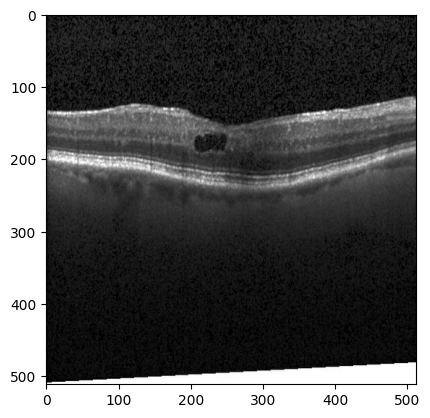

In [221]:
im, msk = read_img(train_path, "10DME_F")
#show the input image
plt.imshow(im)
#obtain the number of channels
chan = preprocess_img(im, True)


### a) Using sklearn, train an SVC model to segment the fluid. Optimize kernel choice (e.g., RBF or polynomial with degree 3) and the cost parameter (C in the range 0.01 to 100) using cross-validation. Measure performance using the Area Under the ROC Curve (roc_auc) and plot the performance of the kernels depending on the C parameter. (Hint: when SVC seems to take an endless time to train, then change your choice of C parameters; large C parameters ® little regularization ® long training time.)

In [222]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import StandardScaler

# CREATE DATASET
y,X = create_training_set(train_path, 500, 11, chan, verbose=True) #jemnote, should be set to 500

# CREATE SUBSECTION
X_sub, y_sub, _ = sub_sample(X, y, sample_size=10000, ratio=200) #jemnote, should be set to 10,000
scaler = StandardScaler()
X_sub_scaled_q4a = scaler.fit_transform(X_sub)

y_bin_q4a = label_binarize(y_sub, classes=[0, 1]).reshape(-1)

# plt.imshow(X_sub[0].reshape(7,7),cmap = 'grey')

Extracting 500 pataches of size 11x11 from each image.
Extracting data from subject: 0
Extracting data from subject: 1
Extracting data from subject: 2
Extracting data from subject: 3
Extracting data from subject: 4
Extracting data from subject: 5
Extracting data from subject: 6
Extracting data from subject: 7
Extracting data from subject: 8
Extracting data from subject: 9
Extracting data from subject: 10


Extracting data from subject: 11
Extracting data from subject: 12
Extracting data from subject: 13
Extracting data from subject: 14
Extracting data from subject: 15
Extracting data from subject: 16
Extracting data from subject: 17
Extracting data from subject: 18
Extracting data from subject: 19
Extracting data from subject: 20
Extracting data from subject: 21
Extracting data from subject: 22
Extracting data from subject: 23
Extracting data from subject: 24
Extracting data from subject: 25
Extracting data from subject: 26
Extracting data from subject: 27
Extracting data from subject: 28
Extracting data from subject: 29
Extracting data from subject: 30
Extracting data from subject: 31
Extracting data from subject: 32
Extracting data from subject: 33
Extracting data from subject: 34
Extracting data from subject: 35
Extracting data from subject: 36
Extracting data from subject: 37
Extracting data from subject: 38
Extracting data from subject: 39
Extracting data from subject: 40
Extracting

In [223]:
from sklearn.model_selection import KFold
from sklearn.model_selection import ParameterGrid

# PARAMETER GRID AND INITIALISATION
param_grid = {'C': [ 0.01, 0.1, 1, 10, 100],
              'kernel': ['poly', 'rbf']} #jemnote, check coursework for values
cv = KFold(n_splits=5, shuffle=False)
results = []

for params in ParameterGrid(param_grid):  # looping through parameters
    print('Currently testing ', params)
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X_sub_scaled_q4a, y_bin_q4a):  # looping through splits
        if any(y_bin_q4a[test]):
            # print(np.unique(X_sub_scaled_q4a[train]), np.unique(X_sub_scaled_q4a[test]), np.unique(y_bin_q4a[train]),np.unique(y_bin_q4a[test]))
            svc = SVC(probability=True, **params)  # set max iteration so it doesn't take years
            prediction = svc.fit(X_sub_scaled_q4a[train], y_bin_q4a[train]).predict_proba(X_sub_scaled_q4a[test])
            fpr, tpr, t = roc_curve(y_bin_q4a[test], prediction[:, 1])
            tprs.append(np.interp(mean_fpr, fpr, tpr))
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
    if tprs:  # Check if there were positive samples in any of the splits
        mean_tpr = np.mean(tprs, axis=0)
        mean_auc = auc(mean_fpr, mean_tpr)
        results.append({'C': params['C'], 'kernel': params['kernel'], 'mean_auc': mean_auc})


poly_results = [result['mean_auc'] for result in results if result['kernel'] == 'poly'] # extract results for plotting
rbf_results = [result['mean_auc'] for result in results if result['kernel'] == 'rbf']

best_result = max(results, key=lambda x: x['mean_auc'])

best_C = best_result['C']
best_kernel = best_result['kernel']

Currently testing  {'C': 0.01, 'kernel': 'poly'}
Currently testing  {'C': 0.01, 'kernel': 'rbf'}
Currently testing  {'C': 0.1, 'kernel': 'poly'}
Currently testing  {'C': 0.1, 'kernel': 'rbf'}
Currently testing  {'C': 1, 'kernel': 'poly'}
Currently testing  {'C': 1, 'kernel': 'rbf'}
Currently testing  {'C': 10, 'kernel': 'poly'}
Currently testing  {'C': 10, 'kernel': 'rbf'}
Currently testing  {'C': 100, 'kernel': 'poly'}
Currently testing  {'C': 100, 'kernel': 'rbf'}


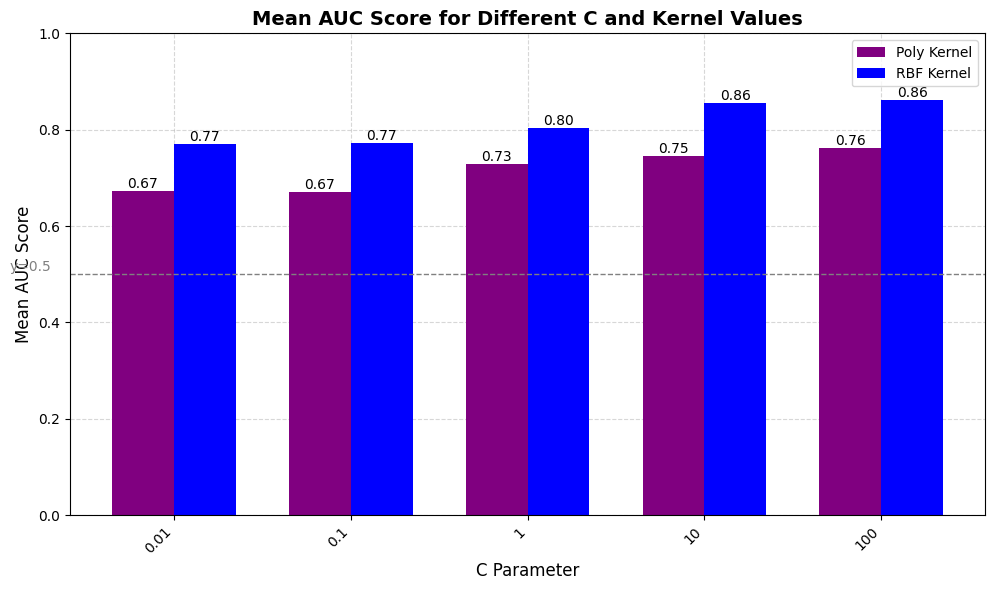

In [224]:
# CREATE THE PLOT
bar_width = 0.35
index = np.arange(len(param_grid['C']))
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(index, poly_results, bar_width, label='Poly Kernel', color = 'purple', zorder=2)
bar2 = ax.bar(index + bar_width, rbf_results, bar_width, label='RBF Kernel', color = 'blue', zorder=2)
ax.set_xlabel('C Parameter', fontsize=12)
ax.set_ylabel('Mean AUC Score', fontsize=12)
ax.set_title('Mean AUC Score for Different C and Kernel Values', fontsize=14, fontweight='bold')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(param_grid['C'], rotation=45, ha='right', fontsize=10)
ax.set_ylim(0, 1)
ax.grid(linestyle='--', alpha=0.5, zorder = 1)
ax.legend(fontsize=10)
for rect1, rect2 in zip(bar1, bar2):
    height1 = rect1.get_height()
    height2 = rect2.get_height()
    ax.text(rect1.get_x() + rect1.get_width() / 2, height1, f'{height1:.2f}', ha='center', va='bottom', fontsize=10)
    ax.text(rect2.get_x() + rect2.get_width() / 2, height2, f'{height2:.2f}', ha='center', va='bottom', fontsize=10)
ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, zorder=2)
ax.text(-0.75, 0.5, 'y=0.5', color='gray', ha='left', va='bottom', fontsize=10)
plt.tight_layout()
plt.savefig('c_kernel_plot.png')

### b) Based on your result from a) select the best model parameters and make predictions of the 50 images in the validation dataset. Compute the DICE coefficient and roc_auc for each image. Display the original image, the ground truth, and your segmentations for any 5 images in your validation set. Provide the average DICE coefficient and roc_auc for the entire validation dataset.

In [225]:
def load_validation_dataset(data_path, patch_dimension,process,chan=1):
    num_images = len(os.listdir(data_path))
    patch_size = patch_dimension * patch_dimension
    amount_of_patches = (512-patch_dimension+1)**2

    X_valid = np.empty((num_images, amount_of_patches, patch_size))
    y_valid = np.empty((num_images, amount_of_patches, patch_size))
    frames_valid = np.empty((num_images, 512, 512, chan + 1))

    for idx, iname in enumerate(os.listdir(data_path)):
        if os.path.isdir(os.path.join(data_path, iname)):
            img_v, mask_v = read_img(data_path, iname)

            mask_v = (mask_v > 0) * 1
            if process == 'original':
                frames = preprocess_img(img_v)
            else:
                frames = preprocess_img_feature(img_v)
            frames = scaler.fit_transform(frames)
            frames = np.dstack((frames, mask_v))
            frames_valid[idx] = frames

            # Sample patches
            patch = image.extract_patches_2d(frames, (patch_dimension, patch_dimension))

            y_temp = patch[:, :, :, 1].reshape(amount_of_patches, patch_size)
            X_temp = patch[:, :, :, 0].reshape(amount_of_patches, patch_size)

            y_valid[idx] = y_temp
            X_valid[idx] = X_temp
    return X_valid, y_valid, frames_valid

In [226]:
def predict_validation(model,X_valid,fast):
    if not fast:
        print("Slow Prediction")
        sp = X_valid.shape
        X_valid = X_valid.reshape(sp[0]*sp[1],sp[2])
        y_pred_val_proba = model.predict_proba(X_valid)[:, 1] # remove the range from x_valid
        y_pred_val_proba = y_pred_val_proba.reshape(sp[0],sp[1])
        y_pred_val_proba_expand = y_pred_val_proba.reshape((sp[0],sp[1]) + (1,))
        y_pred_val_proba_expand = np.tile(y_pred_val_proba_expand, (1, 1, 121))

    else:
        print("Fast Prediction")
        X_valid_fast = X_valid[0:5]
        sp = X_valid_fast.shape
        X_valid_fast = X_valid_fast.reshape(sp[0]*sp[1],sp[2])
        y_pred_val_proba = model.predict_proba(X_valid_fast)[:, 1] # remove the range from x_valid
        y_pred_val_proba = y_pred_val_proba.reshape(sp[0],sp[1])
        y_pred_val_proba_expand = y_pred_val_proba.reshape((sp[0],sp[1]) + (1,))
        y_pred_val_proba_expand = np.tile(y_pred_val_proba_expand, (1, 1, 121))
    return y_pred_val_proba

In [227]:
def metric_calc(mask1, mask2):
    intersect = np.sum(mask1*mask2)
    fsum = np.sum(mask1)
    ssum = np.sum(mask2)
    dice = (2 * intersect ) / (fsum + ssum)
    dice = np.mean(dice)
    dice = round(dice, 3)

    unique_classes = np.unique(np.where(mask1 > 0.5, 1, 0))
    if len(unique_classes) < 2:
        roc_auc = 0  # or any other value to indicate undefined ROC AUC
    else:
        # Ensure labels are binary or multilabel indicator format
        if len(unique_classes) == 2:
            roc_auc = roc_auc_score(np.where(mask1.flatten() > 0.5, 1, 0), np.where(mask2.flatten() > threshold, 1, 0))
        else:
            roc_auc = roc_auc_score(mask1.flatten(), mask2.flatten())
            
    return dice, roc_auc

In [228]:
def dice_and_roc_auc_calc(frames_valid,y_pred_val_proba ):
    dice_values = []
    roc_auc_values =  []
    for valid_images in range(len(y_pred_val_proba)):
        dice, roc_auc = metric_calc(frames_valid[valid_images, :, :, 1],np.pad(y_pred_val_proba[valid_images].reshape(502,502), ((5, 5), (5, 5)), mode='constant')) 
        dice_values.append(dice)
        roc_auc_values.append(roc_auc)

    mean_dice = sum(dice_values)/len(dice_values)
    mean_roc_values = sum(roc_auc_values)/len(roc_auc_values)

    print("Overall mean dice coefficient", mean_dice, '\nOverall AUC values', mean_roc_values)
    return mean_dice, mean_roc_values

In [229]:
X_valid, y_valid,frames_valid = load_validation_dataset(vali_path,11, 'original')
model = SVC(kernel=best_kernel, C=best_C, probability=True,verbose=1)
model.fit(X_sub_scaled_q4a, y_bin_q4a)

[LibSVM]............................*................*
optimization finished, #iter = 44217
obj = -45859.840450, rho = 1.824103
nSV = 1779, nBSV = 279
Total nSV = 1779
.............................*..............*
optimization finished, #iter = 43530
obj = -47320.796465, rho = 1.799164
nSV = 1760, nBSV = 289
Total nSV = 1760
..............................*............*
optimization finished, #iter = 42263
obj = -44997.192626, rho = 1.695132
nSV = 1732, nBSV = 280
Total nSV = 1732
...............................*...............*
optimization finished, #iter = 46416
obj = -46336.225804, rho = 1.871345
nSV = 1791, nBSV = 271
Total nSV = 1791
...........................*................*
optimization finished, #iter = 43877
obj = -46370.968370, rho = 1.750315
nSV = 1792, nBSV = 279
Total nSV = 1792
........................................*..................*
optimization finished, #iter = 58694
obj = -60672.380922, rho = -2.320026
nSV = 2164, nBSV = 368
Total nSV = 2164


SVC(C=100, probability=True, verbose=1)

In [230]:
y_pred_val_proba = predict_validation(model,X_valid,True)

Fast Prediction


In [231]:
# IMPORTANT THRESHOLD FROM PREDICTED VALUES
threshold = 0.7

In [232]:
# RETRIEVING DICE COEFFICIENT AND ROC_AUC
mean_dice, mean_roc_values = dice_and_roc_auc_calc(frames_valid,y_pred_val_proba)

Overall mean dice coefficient 0.0254 
Overall AUC values 0.5818493036234985


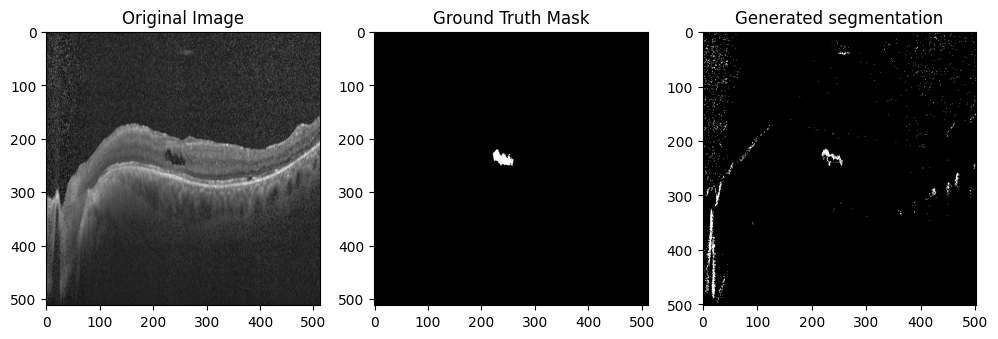

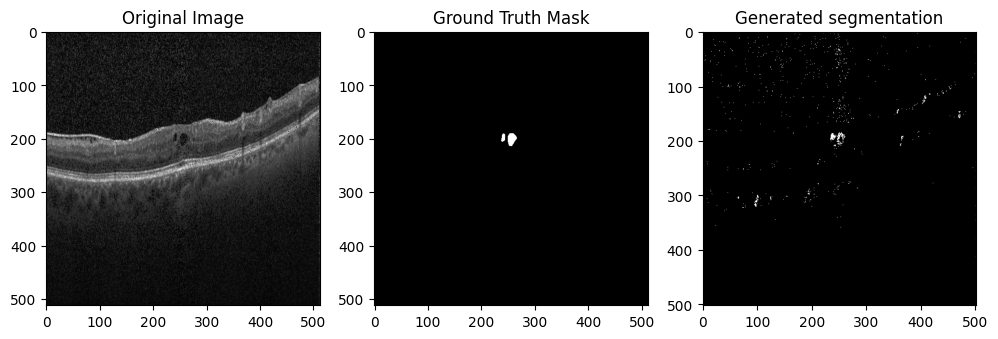

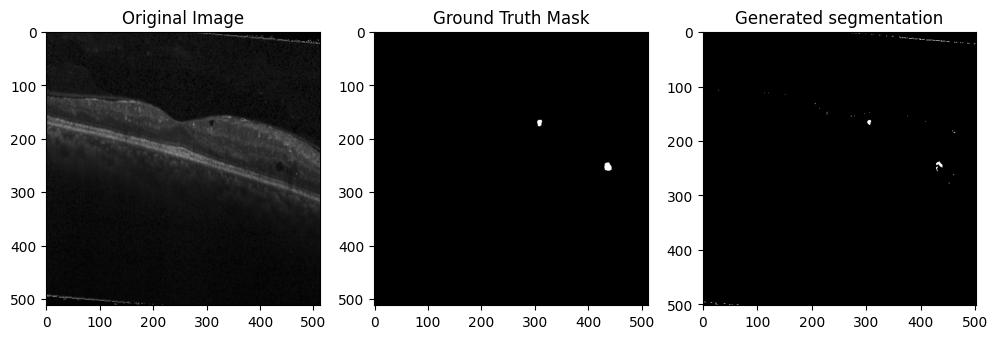

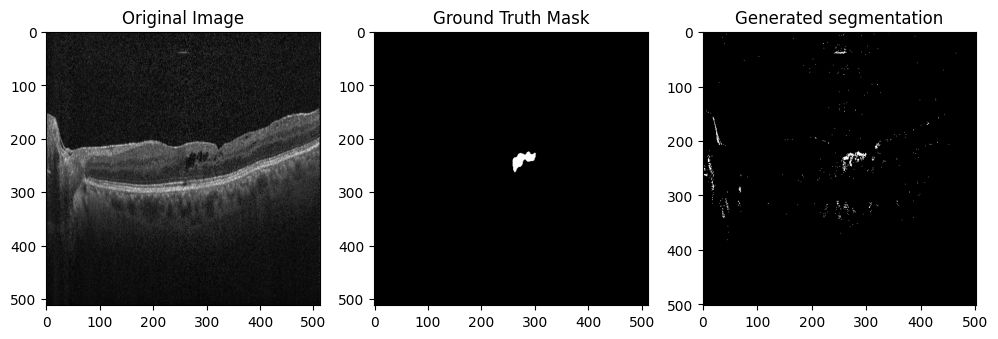

In [233]:
# PLOTTING 5 IMAGES
for i in range(1,5):
    plt.figure(figsize=(12, 4))  # Adjust the figsize as needed
    # Plot the original image
    plt.subplot(1, 3, 1)
    plt.imshow(frames_valid[i, :, :, 0], cmap='gray')
    plt.title('Original Image')

    # Plot the ground truth mask
    plt.subplot(1, 3, 2)
    plt.imshow(frames_valid[i, :, :, 1], cmap='gray')
    plt.title('Ground Truth Mask')


    plt.subplot(1, 3, 3)
    plt.imshow(np.where(y_pred_val_proba[i].reshape(502,502) > threshold, 1, 0), cmap='gray')
    plt.title('Generated segmentation')


### c) Instead of the SVC, train a tree-based ensemble classifier and make predictions for the validation images. Report the average DICE coefficient for the entire validation set. What performs better the SVC or the tree ensemble?

In [234]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_sub_scaled_q4a, y_bin_q4a)

RandomForestClassifier(random_state=42)

In [235]:
# VALIDATION DATA
X_valid, y_valid, frames_valid = load_validation_dataset(vali_path, 11,'original')
y_pred_val_proba = predict_validation(rf_classifier,X_valid,fast = True)

Fast Prediction


In [236]:
mean_dice, mean_roc_values = dice_and_roc_auc_calc(frames_valid,y_pred_val_proba)

/var/folders/bg/bmn7by4x15sgj4tt20j628pm0000gn/T/ipykernel_83927/944038944.py:5: RuntimeWarning: invalid value encountered in scalar divide
  dice = (2 * intersect ) / (fsum + ssum)


Overall mean dice coefficient nan 
Overall AUC values 0.5358816337268302


### d) Use the tree-based ensemble method and explore how the amount of training data (i.e., sub sample size: 500, 1000, 5000, 10000, 20000), the patch dimensions (3x3, 7x7, 11x11, 15x15, 19x19), and the sampling ratio (50,100,200,400,800) affects the performance on the validation set.

In [237]:
sub_sample_sizes_values = [500,100,5000,10000,20000]
patch_dimensions_values = [3,7,11,15,19]
sampling_ratios_values = [50,100,200,400,800]

results_dict = {}

for sample_size in sub_sample_sizes_values:
    for patch_dimension in patch_dimensions_values:
        for sampling_ratio in sampling_ratios_values:
            print('\nCURRENT PARAMETERS: sub-sample size',sample_size,', patch dimensions',patch_dimension,'x',patch_dimension,', Sampling ratio',sampling_ratio)
            y,X = create_training_set(train_path, 500, patch_dimension, chan, verbose=False) #jemnote, should be set to 500
            # CREATE SUBSECTION
            X_sub, y_sub, _ = sub_sample(X, y, sample_size, sampling_ratio) #jemnote, should be set to 10,000
            scaler = StandardScaler()
            X_sub_scaled = scaler.fit_transform(X_sub)

            y_bin = label_binarize(y_sub, classes=[0, 1]).reshape(-1)

            rf_classifier.fit(X_sub_scaled, y_bin)

            X_valid_tree, y_valid_tree, frames_valid_tree = load_validation_dataset(vali_path, patch_dimension,'original')
            X_valid_tree = np.array(X_valid_tree)
            y_pred_val_proba_tree = predict_validation(rf_classifier,X_valid_tree,fast = True)

            dice_values = []
            roc_auc_values =  []
            for valid_images in range(len(y_pred_val_proba_tree)):
                pad = int((patch_dimension-1)/2)
                dice, roc_auc = metric_calc(frames_valid[valid_images, :, :, 1],np.pad(y_pred_val_proba_tree[valid_images].reshape(513-patch_dimension,513-patch_dimension), ((pad, pad), (pad, pad)), mode='constant')) #jemnote, change this to actually look at generated values
                dice_values.append(dice)
                roc_auc_values.append(roc_auc)

            mean_dice_tree = sum(dice_values)/len(dice_values)
            mean_roc_values_tree = sum(roc_auc_values)/len(roc_auc_values)

            print("Overall mean dice coefficient", mean_dice_tree, '\nOverall AUC values', mean_roc_values_tree)
            results_dict[(sample_size, patch_dimension, sampling_ratio)] = {'mean_dice_tree': mean_dice_tree,
                                                                            'mean_roc_values_tree': mean_roc_values_tree}

            


CURRENT PARAMETERS: sub-sample size 500 , patch dimensions 3 x 3 , Sampling ratio 50
Fast Prediction
Overall mean dice coefficient 0.006 
Overall AUC values 0.4052902377769964

CURRENT PARAMETERS: sub-sample size 500 , patch dimensions 3 x 3 , Sampling ratio 100
Fast Prediction
Overall mean dice coefficient 0.005 
Overall AUC values 0.41823721726137003

CURRENT PARAMETERS: sub-sample size 500 , patch dimensions 3 x 3 , Sampling ratio 200
Fast Prediction
Overall mean dice coefficient 0.0048000000000000004 
Overall AUC values 0.47735182233193996

CURRENT PARAMETERS: sub-sample size 500 , patch dimensions 3 x 3 , Sampling ratio 400
Fast Prediction
Overall mean dice coefficient 0.004399999999999999 
Overall AUC values 0.5249672391850617

CURRENT PARAMETERS: sub-sample size 500 , patch dimensions 3 x 3 , Sampling ratio 800
Fast Prediction
Overall mean dice coefficient 0.004 
Overall AUC values 0.5111414346094009

CURRENT PARAMETERS: sub-sample size 500 , patch dimensions 7 x 7 , Sampling r

: 

In [ ]:
best_entry = max(results_dict.items(), key=lambda x: x[1]['mean_dice'] + x[1]['mean_roc_values'])

# Access the sample_size, patch_dimension, sampling_ratio, mean_dice, and mean_roc_values
best_sample_size, best_patch_dimension, best_sampling_ratio = best_entry[0]
best_mean_dice = best_entry[1]['mean_dice']
best_mean_roc_values = best_entry[1]['mean_roc_values']

# Print or use the best values as needed
print("Best Parameters:")
print("Sample Size:", best_sample_size)
print("Patch Dimension:", best_patch_dimension)
print("Sampling Ratio:", best_sampling_ratio)
print("Best Mean Dice Coefficient:", best_mean_dice)
print("Best Mean ROC Values:", best_mean_roc_values)

In [ ]:
# Extract data for plotting
parameter_values = list(results_dict.keys())
mean_dice_values = [value['mean_dice'] for value in results_dict.values()]
mean_roc_values = [value['mean_roc_values'] for value in results_dict.values()]

# Create an index array for the bar plot
index = np.arange(len(parameter_values))

# Plotting bar plot
bar_width = 0.35
fig, ax = plt.subplots(figsize=(12, 8))

bar1 = ax.bar(index, mean_dice_values, bar_width, label='Mean Dice', color='r')
bar2 = ax.bar(index + bar_width, mean_roc_values, bar_width, label='Mean ROC', color='b')

# Labeling and formatting
ax.set_xlabel('Parameter Values')
ax.set_ylabel('Mean Value')
ax.set_title('Mean Dice and Mean ROC Values for Different Parameters')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(parameter_values, rotation='vertical')
ax.legend()

plt.show()

### e) Modify the function preprocess_img to add at least one additional channel (feature) that will improve the performance on the validation data. (Hint: the scikit-image library offers various filters that might provide good features.) Report how these features influence the model’s performance.

In [ ]:
#if the variable nchan is sset to True, then the return is just the number of channels
from skimage import exposure, restoration, filters
import numpy as np
from skimage.color import rgb2gray

def preprocess_img_feature(img, nchan=False):
    res = img[:,:,1]
    res_processed = res.copy()
    # Histogram equalization for contrast enhancement
    res_processed = exposure.equalize_hist(res_processed)

    # Denoise the image
    res_processed = restoration.denoise_tv_chambolle(res_processed, weight=0.2)

    # Apply edge detection
    res_processed = np.dstack((res_processed, filters.sobel(img[:, :, 1]) * 255))

    # Normalize pixel values
    res_processed = res_processed / 255.0
    res = np.dstack((res, res_processed))
    if nchan:
        try:
            return(res.shape[2])
        except IndexError:
            return(1)
    return (res)

In [ ]:
y,X = create_training_set(train_path, 500, best_patch_dimension, 1, verbose=False) #jemnote, should be set to 500
# CREATE SUBSECTION
X_sub_2, y_sub_2, _ = sub_sample(X, y, best_sample_size, best_sampling_ratio) #jemnote, should be set to 10,000
scaler = StandardScaler()
X_sub_2_scaled = scaler.fit_transform(X_sub_2)

y_bin = label_binarize(y_sub_2, classes=[0, 1]).reshape(-1)

rf_classifier.fit(X_sub_2_scaled, y_bin)

X_valid, y_valid, frames_valid = load_validation_dataset(vali_path, best_patch_dimension, 'original', chan = 1)
X_valid = np.array(X_valid)
y_pred_val_proba = predict_validation(rf_classifier,X_valid,fast = True)

dice_values = []
roc_auc_values =  []
for valid_images in range(len(y_pred_val_proba)):
    pad = int((best_patch_dimension-1)/2)
    dice, roc_auc = metric_calc(frames_valid[valid_images, :, :, 1],np.pad(y_pred_val_proba[valid_images].reshape(513-best_patch_dimension,513-best_patch_dimension), ((pad, pad), (pad, pad)), mode='constant')) #jemnote, change this to actually look at generated values
    dice_values.append(dice)
    roc_auc_values.append(roc_auc)

mean_dice = sum(dice_values)/len(dice_values)
mean_roc_values = sum(roc_auc_values)/len(roc_auc_values)

print("Overall mean dice coefficient", mean_dice, '\nOverall AUC values', mean_roc_values)

### f) Using your best combination of training data size, patch dimension, sampling ratio (from d) and filter set (from e), estimate the performance on unseen samples from the test set. Provide average DICE coefficient for the entire test set.